<h1> ELO Merchant Category Recommendation </h1>
<h2> Part V - Final Models and Ensembling </h2>

This notebook covers the three main models used to make the final Kaggle prediction. It also looks at the huge role that outliers ended up playing in this competition.

In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [160]:
# Basic Packages
import pandas as pd
import numpy as np
import datetime
import time
import warnings
warnings.filterwarnings('ignore')

# plotting packages
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['bmh'])
%matplotlib inline

# machine learning packages
import lightgbm as lgb
from sklearn import linear_model
from sklearn import model_selection, preprocessing, metrics
pd.set_option('display.max_columns',None)
from sklearn.metrics import mean_squared_error

In [146]:
plt.style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'tableau-colorblind10',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

First we will load our final train and test dataframes that we created in our first three notebooks.

In [4]:
# Load data from final train and test sets created in Part III
train = pd.read_csv('final_train.csv')
test = pd.read_csv('final_test.csv')
display(train.head())
display(test.head())

,card_id,feature_1,feature_2,feature_3,target,month,elapsed_time,hist_authorized_flag_mean,hist_card_id_count,hist_city_id_nunique,hist_category_1_sum,hist_category_1_mean,hist_category_1_std,hist_category_2_1.0_sum,hist_category_2_1.0_mean,hist_category_2_2.0_sum,hist_category_2_2.0_mean,hist_category_2_3.0_sum,hist_category_2_3.0_mean,hist_category_2_4.0_sum,hist_category_2_4.0_mean,hist_category_2_5.0_sum,hist_category_2_5.0_mean,hist_category_3_A_sum,hist_category_3_A_mean,hist_category_3_B_sum,hist_category_3_B_mean,hist_category_3_C_sum,hist_category_3_C_mean,hist_month_nunique,hist_hour_mean,hist_weekofyear_mean,hist_weekofyear_nunique,hist_day_nunique,hist_day_ptp,hist_day_mean,hist_dayofweek_mean,hist_weekend_sum,hist_weekend_mean,hist_duration_min,hist_duration_mean,hist_duration_max,hist_price_sum,hist_price_mean,hist_price_max,hist_price_min,hist_price_var,hist_amount_month_ratio_max,hist_amount_month_ratio_min,hist_amount_month_ratio_ptp,hist_installments_sum,hist_installments_min,hist_installments_max,hist_installments_var,hist_installments_mean,hist_merchant_category_id_nunique,hist_merchant_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_var,hist_purchase_amount_median,hist_purchase_date_max,hist_purchase_date_min,hist_purchase_date_ptp,hist_time_since_purchase_date_min,hist_time_since_purchase_date_max,hist_time_since_purchase_date_mean,hist_month_lag_min,hist_month_lag_max,hist_month_lag_mean,hist_month_lag_var,hist_month_lag_ptp,hist_month_diff_mean,hist_month_diff_min,hist_month_diff_max,hist_month_diff_ptp,hist_month_diff_var,hist_store_size_min,hist_store_size_max,hist_store_size_mean,hist_city_size_min,hist_city_size_max,hist_city_size_mean,hist_state_size_min,hist_state_size_max,hist_state_size_mean,hist_subsector_size_min,hist_subsector_size_max,hist_subsector_size_mean,hist_category_size_min,hist_category_size_max,hist_category_size_mean,new_card_id_count,new_city_id_nunique,new_category_1_sum,new_category_1_mean,new_category_2_1.0_sum,new_category_2_1.0_mean,new_category_2_2.0_sum,new_category_2_2.0_mean,new_category_2_3.0_sum,new_category_2_3.0_mean,new_category_2_4.0_sum,new_category_2_4.0_mean,new_category_2_5.0_sum,new_category_2_5.0_mean,new_category_3_A_sum,new_category_3_A_mean,new_category_3_B_sum,new_category_3_B_mean,new_category_3_C_sum,new_category_3_C_mean,new_month_nunique,new_weekofyear_nunique,new_day_nunique,new_day_ptp,new_day_mean,new_dayofweek_mean,new_duration_min,new_duration_max,new_price_sum,new_price_mean,new_price_max,new_price_min,new_price_var,new_amount_month_ratio_max,new_amount_month_ratio_min,new_amount_month_ratio_ptp,new_installments_sum,new_installments_min,new_installments_max,new_installments_var,new_installments_mean,new_merchant_category_id_nunique,new_merchant_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_var,new_purchase_date_max,new_purchase_date_min,new_purchase_date_ptp,new_time_since_purchase_date_min,new_time_since_purchase_date_max,new_time_since_purchase_date_mean,new_weekend_sum,new_weekend_mean,new_month_lag_min,new_month_lag_max,new_month_lag_mean,new_month_lag_var,new_month_lag_ptp,new_month_diff_mean,new_month_diff_min,new_month_diff_max,new_month_diff_ptp,max_repeat_purchases,mean_repeat_purchases,mean_merchant_purchases,mean_category_purchases,mean_monthly_purchases,hist_purchase_date_uptonow,new_purchase_date_uptonow,quarter,days_feature1,days_feature2,days_feature3,days_feature1_ratio,days_feature2_ratio,days_feature3_ratio,first_month,first_year,category_1_mean,new_CLV,hist_CLV,transactions_ratio,mean_purchase_ratio,max_purchase_ratio,sum_purchase_amount_ratio,mean_month_lag_ratio,mean_month_diff_ratio,sum_installments_ratio,mean_installments_ratio,min_duration_ratio,transactions_product,mean_purchase_product,max_purchase_product,sum_purchase_amount_product,mean_month_lag_product

,card_id,feature_1,feature_2,feature_3,month,elapsed_time,hist_authorized_flag_mean,hist_card_id_count,hist_city_id_nunique,hist_category_1_sum,hist_category_1_mean,hist_category_1_std,hist_category_2_1.0_sum,hist_category_2_1.0_mean,hist_category_2_2.0_sum,hist_category_2_2.0_mean,hist_category_2_3.0_sum,hist_category_2_3.0_mean,hist_category_2_4.0_sum,hist_category_2_4.0_mean,hist_category_2_5.0_sum,hist_category_2_5.0_mean,hist_category_3_A_sum,hist_category_3_A_mean,hist_category_3_B_sum,hist_category_3_B_mean,hist_category_3_C_sum,hist_category_3_C_mean,hist_month_nunique,hist_hour_mean,hist_weekofyear_mean,hist_weekofyear_nunique,hist_day_nunique,hist_day_ptp,hist_day_mean,hist_dayofweek_mean,hist_weekend_sum,hist_weekend_mean,hist_duration_min,hist_duration_mean,hist_duration_max,hist_price_sum,hist_price_mean,hist_price_max,hist_price_min,hist_price_var,hist_amount_month_ratio_max,hist_amount_month_ratio_min,hist_amount_month_ratio_ptp,hist_installments_sum,hist_installments_min,hist_installments_max,hist_installments_var,hist_installments_mean,hist_merchant_category_id_nunique,hist_merchant_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_var,hist_purchase_amount_median,hist_purchase_date_max,hist_purchase_date_min,hist_purchase_date_ptp,hist_time_since_purchase_date_min,hist_time_since_purchase_date_max,hist_time_since_purchase_date_mean,hist_month_lag_min,hist_month_lag_max,hist_month_lag_mean,hist_month_lag_var,hist_month_lag_ptp,hist_month_diff_mean,hist_month_diff_min,hist_month_diff_max,hist_month_diff_ptp,hist_month_diff_var,hist_store_size_min,hist_store_size_max,hist_store_size_mean,hist_city_size_min,hist_city_size_max,hist_city_size_mean,hist_state_size_min,hist_state_size_max,hist_state_size_mean,hist_subsector_size_min,hist_subsector_size_max,hist_subsector_size_mean,hist_category_size_min,hist_category_size_max,hist_category_size_mean,new_card_id_count,new_city_id_nunique,new_category_1_sum,new_category_1_mean,new_category_2_1.0_sum,new_category_2_1.0_mean,new_category_2_2.0_sum,new_category_2_2.0_mean,new_category_2_3.0_sum,new_category_2_3.0_mean,new_category_2_4.0_sum,new_category_2_4.0_mean,new_category_2_5.0_sum,new_category_2_5.0_mean,new_category_3_A_sum,new_category_3_A_mean,new_category_3_B_sum,new_category_3_B_mean,new_category_3_C_sum,new_category_3_C_mean,new_month_nunique,new_weekofyear_nunique,new_day_nunique,new_day_ptp,new_day_mean,new_dayofweek_mean,new_duration_min,new_duration_max,new_price_sum,new_price_mean,new_price_max,new_price_min,new_price_var,new_amount_month_ratio_max,new_amount_month_ratio_min,new_amount_month_ratio_ptp,new_installments_sum,new_installments_min,new_installments_max,new_installments_var,new_installments_mean,new_merchant_category_id_nunique,new_merchant_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_var,new_purchase_date_max,new_purchase_date_min,new_purchase_date_ptp,new_time_since_purchase_date_min,new_time_since_purchase_date_max,new_time_since_purchase_date_mean,new_weekend_sum,new_weekend_mean,new_month_lag_min,new_month_lag_max,new_month_lag_mean,new_month_lag_var,new_month_lag_ptp,new_month_diff_mean,new_month_diff_min,new_month_diff_max,new_month_diff_ptp,max_repeat_purchases,mean_repeat_purchases,mean_merchant_purchases,mean_category_purchases,mean_monthly_purchases,hist_purchase_date_uptonow,new_purchase_date_uptonow,quarter,days_feature1,days_feature2,days_feature3,days_feature1_ratio,days_feature2_ratio,days_feature3_ratio,first_month,first_year,category_1_mean,new_CLV,hist_CLV,transactions_ratio,mean_purchase_ratio,max_purchase_ratio,sum_purchase_amount_ratio,mean_month_lag_ratio,mean_month_diff_ratio,sum_installments_ratio,mean_installments_ratio,min_duration_ratio,transactions_product,mean_purchase_product,max_purchase_product,sum_purchase_amount_product,mean_month_lag_product,mean_m

In [5]:
# Features that our model shouldnt use
useless_features = ['target',
                    'card_id',
                    'new_authorized_flag_mean',
                    'outliers'
                   ]

# Features Found Not to Be Useful in PART IV
drop_features = ['feature_2',
                 'feature_3',
                 'hist_city_id_nunique',
                 'hist_category_2_1.0_mean',
                 'hist_category_2_2.0_sum',
                 'hist_category_2_2.0_mean',
                 'hist_category_2_3.0_sum',
                 'hist_category_2_3.0_mean',
                 'hist_category_2_5.0_sum',
                 'hist_category_2_5.0_mean',
                 'hist_day_ptp',
                 'hist_duration_mean',
                 'hist_amount_month_ratio_ptp',
                 'hist_installments_min',
                 'hist_purchase_amount_sum',
                 'hist_purchase_amount_var',
                 'hist_month_diff_ptp',
                 'hist_store_size_max',
                 'hist_city_size_max',
                 'hist_state_size_min',
                 'hist_state_size_max',
                 'new_city_id_nunique',
                 'new_category_2_1.0_sum',
                 'new_category_2_2.0_sum',
                 'new_category_2_2.0_mean',
                 'new_category_2_3.0_sum',
                 'new_category_2_3.0_mean',
                 'new_category_2_4.0_sum',
                 'new_category_2_4.0_mean',
                 'new_category_2_5.0_sum',
                 'new_category_2_5.0_mean',
                 'new_category_3_A_mean',
                 'new_category_3_B_sum',
                 'new_category_3_C_sum',
                 'new_category_3_C_mean',
                 'new_dayofweek_mean',
                 'new_installments_min',
                 'new_installments_max',
                 'new_installments_var',
                 'new_weekend_sum',
                 'new_weekend_mean',
                 'new_month_diff_min',
                 'new_month_diff_ptp',
                 'quarter',
                 'min_duration_ratio',
                 'max_purchase_product']

features = [name for name in train.columns if name not in useless_features+drop_features]
target = train['target']

# Dealing with outliers
train['outliers'] = 0
train.loc[train['target'] < -30,'outliers'] = 1

## Final Models

The final submission utilized three main models trained at different depths for added variety for simplicity only the top performing depths were featured here.  The highest scoring single model was a LGBM model at 7 depth. The other two models were created to try and mitigate the error/effect of outliers. In addition to the top performing model, a classifier model was added which was trained to predict outliers. Additionally an LGBM model trained using Huber Regression was added to be less bias towards outliers. The outputs of these three models were then combined in a linear model and cross validated to determine optimal model weights for each.

### 1. LGBM Model (Best Single Model)

In [6]:
def lgb_cv(features,params,splits,rs=15):
    folds = model_selection.StratifiedKFold(n_splits=splits,shuffle=True,random_state=rs)
    lgb_oof = np.zeros(len(train))
    lgb_pred = np.zeros(len(test))
    lgb_feature_importance = pd.DataFrame()

    for fold_, (train_index,valid_index) in enumerate(folds.split(train,train['outliers'].values)):
        print(f"fold number: {fold_ + 1}")

        train_data = lgb.Dataset(train.iloc[train_index][features],label=target.iloc[train_index])
        val_data = lgb.Dataset(train.iloc[valid_index][features],label=target.iloc[valid_index])
        num_rounds = 10000
        lgb_model = lgb.train(params,
                        train_data,
                        num_rounds,
                        valid_sets=[train_data,val_data],
                        verbose_eval=0,
                        early_stopping_rounds=200)
        lgb_oof[valid_index] = lgb_model.predict(train.iloc[valid_index][features],num_iteration=lgb_model.best_iteration)
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature'] = features
        fold_importance_df['importance'] = lgb_model.feature_importance()
        fold_importance_df['fold'] = fold_ + 1
        lgb_feature_importance = pd.concat([lgb_feature_importance,fold_importance_df],axis=0)
        lgb_pred += lgb_model.predict(test[features],num_iteration=lgb_model.best_iteration)/folds.n_splits
    return lgb_oof,lgb_pred,lgb_feature_importance

In [7]:
# Train LGBM Model
params ={
        'task': 'train',
        'boosting': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.01,
        'subsample': 0.95,
        'max_depth': 7,
        'num_leaves': 64,
        'min_child_weight': 42,
        'reg_alpha': 9.7,
        'colsample_bytree': 0.57,
        'min_split_gain': 9.8,
        'reg_lambda': 8.25,
        'min_data_in_leaf': 21,
        'verbose': -1,
        'seed':2333,
        }

state = 15
lgb_oof,lgb_pred,lgb_feature_importance = lgb_cv(features,params,5,state)
print('RMSE:',np.sqrt(mean_squared_error(lgb_oof, target)))
print('~'*20)

fold number: 1
fold number: 2
fold number: 3
fold number: 4
fold number: 5
RMSE: 3.6460893290168004
~~~~~~~~~~~~~~~~~~~~


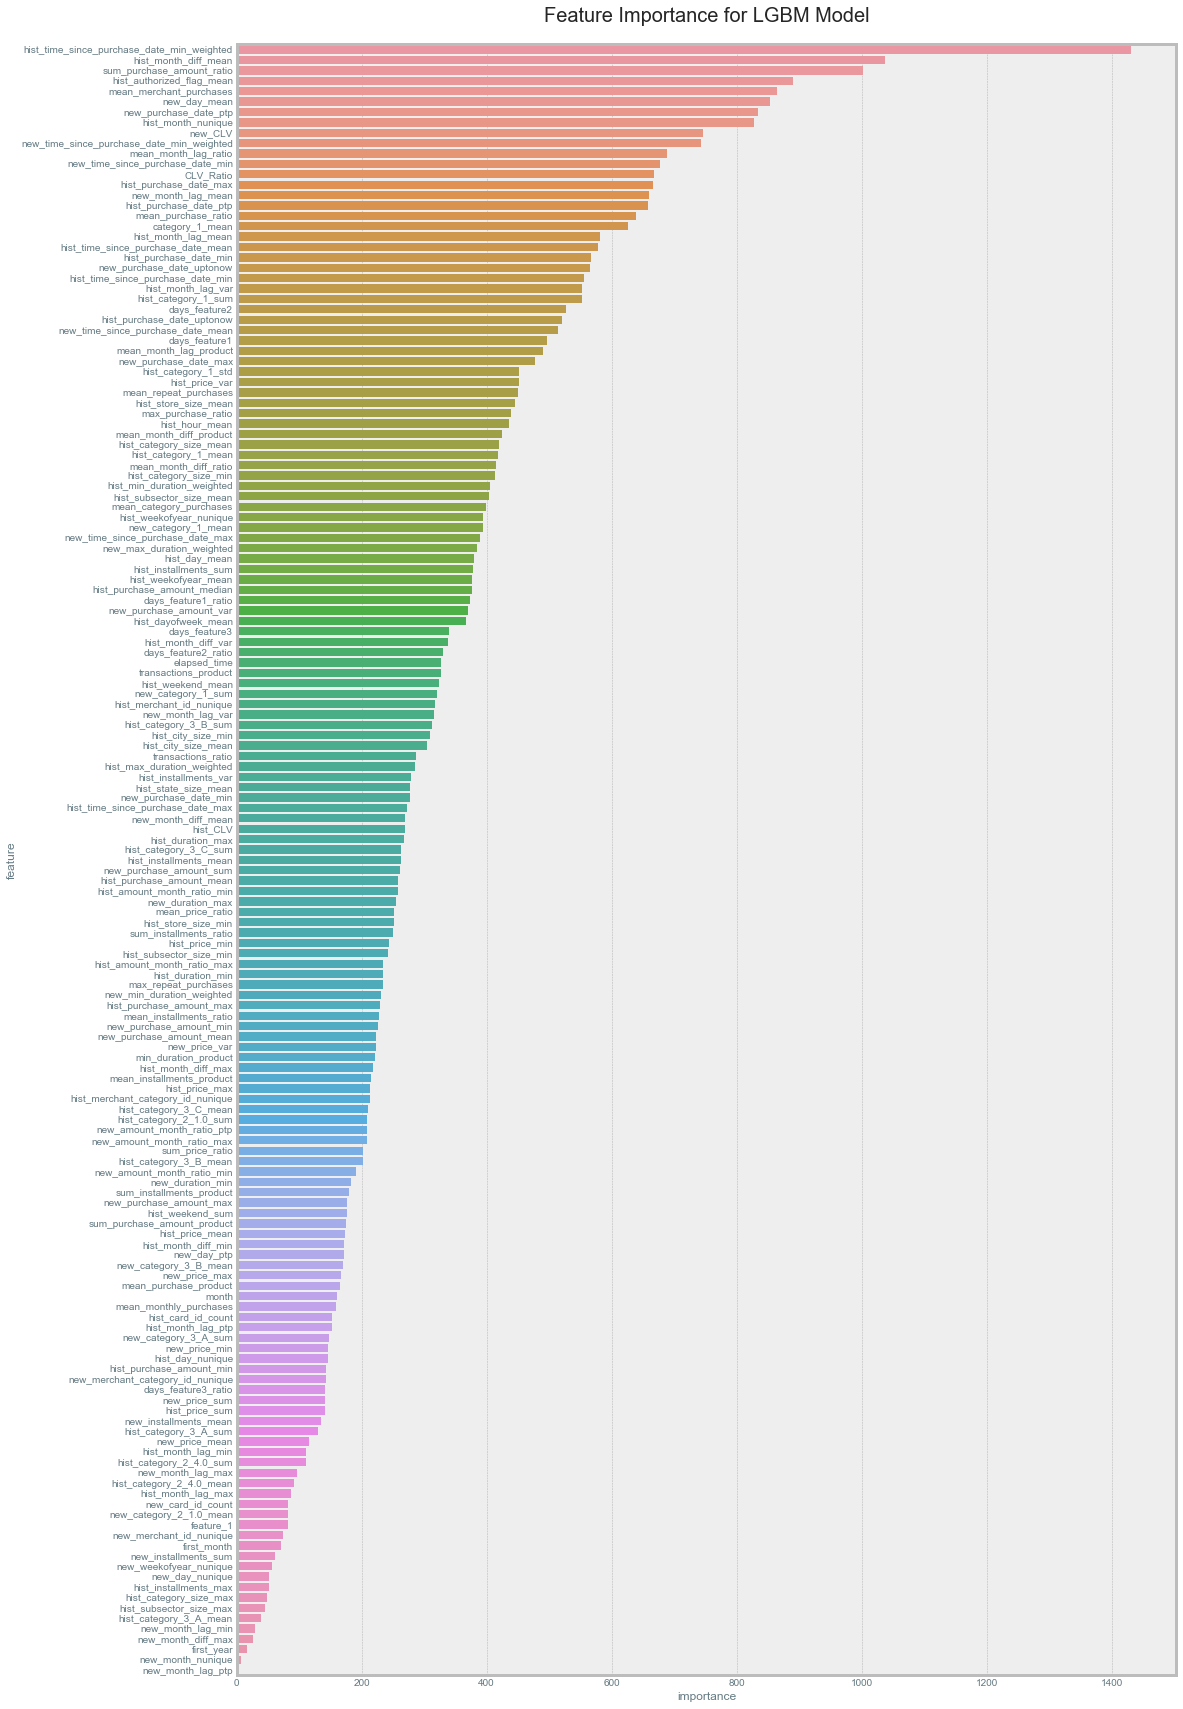

In [161]:
plt.figure(figsize=(15,30))
lgbm_feature_imp_df = lgb_feature_importance.groupby('feature').mean().reset_index()
lgbm_feature_imp_df.sort_values('importance',inplace = True,ascending=False)
sns.barplot(y='feature',x='importance',data=lgbm_feature_imp_df)
plt.title('Feature Importance for LGBM Model',size=20,y=1.01)
plt.show()

### 2. LGBM Outlier Classifier (Outputs Outlier Probabilities )

In [10]:
def classifier_cv(features,params,splits,rs=15):
    folds = model_selection.StratifiedKFold(n_splits=splits,shuffle=True,random_state=rs)
    class_oof = np.zeros(len(train))
    class_pred = np.zeros(len(test))
    classifier_feature_importance = pd.DataFrame()

    for fold_, (train_index,valid_index) in enumerate(folds.split(train,train['outliers'].values)):
        print(f"fold number: {fold_ + 1}")
        train_data = lgb.Dataset(train.iloc[train_index][features],label=train['outliers'].iloc[train_index])
        val_data = lgb.Dataset(train.iloc[valid_index][features],label=train['outliers'].iloc[valid_index])
        num_rounds = 10000
        clf = lgb.train(params,
                        train_data,
                        num_rounds,
                        valid_sets=[train_data,val_data],
                        verbose_eval=200,
                        early_stopping_rounds=200)
        class_oof[valid_index] = clf.predict(train.iloc[valid_index][features],num_iteration=clf.best_iteration)
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature'] = features
        fold_importance_df['importance'] = clf.feature_importance()
        fold_importance_df['fold'] = fold_ + 1
        classifier_feature_importance = pd.concat([classifier_feature_importance,fold_importance_df],axis=0)
        class_pred += clf.predict(test[features],num_iteration=clf.best_iteration)/folds.n_splits
    return class_oof,class_pred,classifier_feature_importance

In [12]:
class_params = {'num_leaves': 31,
         'min_data_in_leaf': 30,
         'objective':'binary',
         'max_depth': 7,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "min_child_samples":20,
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 133,
         "nthread":4,
         "verbosity": -1}

class_oof,class_pred,class_feature_importance = classifier_cv(features,class_params,5,state)

fold number: 1
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.951563	valid_1's auc: 0.891516
[400]	training's auc: 0.975071	valid_1's auc: 0.894071
[600]	training's auc: 0.984055	valid_1's auc: 0.894136
[800]	training's auc: 0.989833	valid_1's auc: 0.893621
Early stopping, best iteration is:
[610]	training's auc: 0.984322	valid_1's auc: 0.894231
fold number: 2
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.952019	valid_1's auc: 0.892998
[400]	training's auc: 0.976175	valid_1's auc: 0.895727
[600]	training's auc: 0.984846	valid_1's auc: 0.89607
Early stopping, best iteration is:
[586]	training's auc: 0.984374	valid_1's auc: 0.896118
fold number: 3
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.948875	valid_1's auc: 0.902077
[400]	training's auc: 0.974914	valid_1's auc: 0.906296
[600]	training's auc: 0.984335	valid_1's auc: 0.906514
Early stopping, best iteration is:
[4

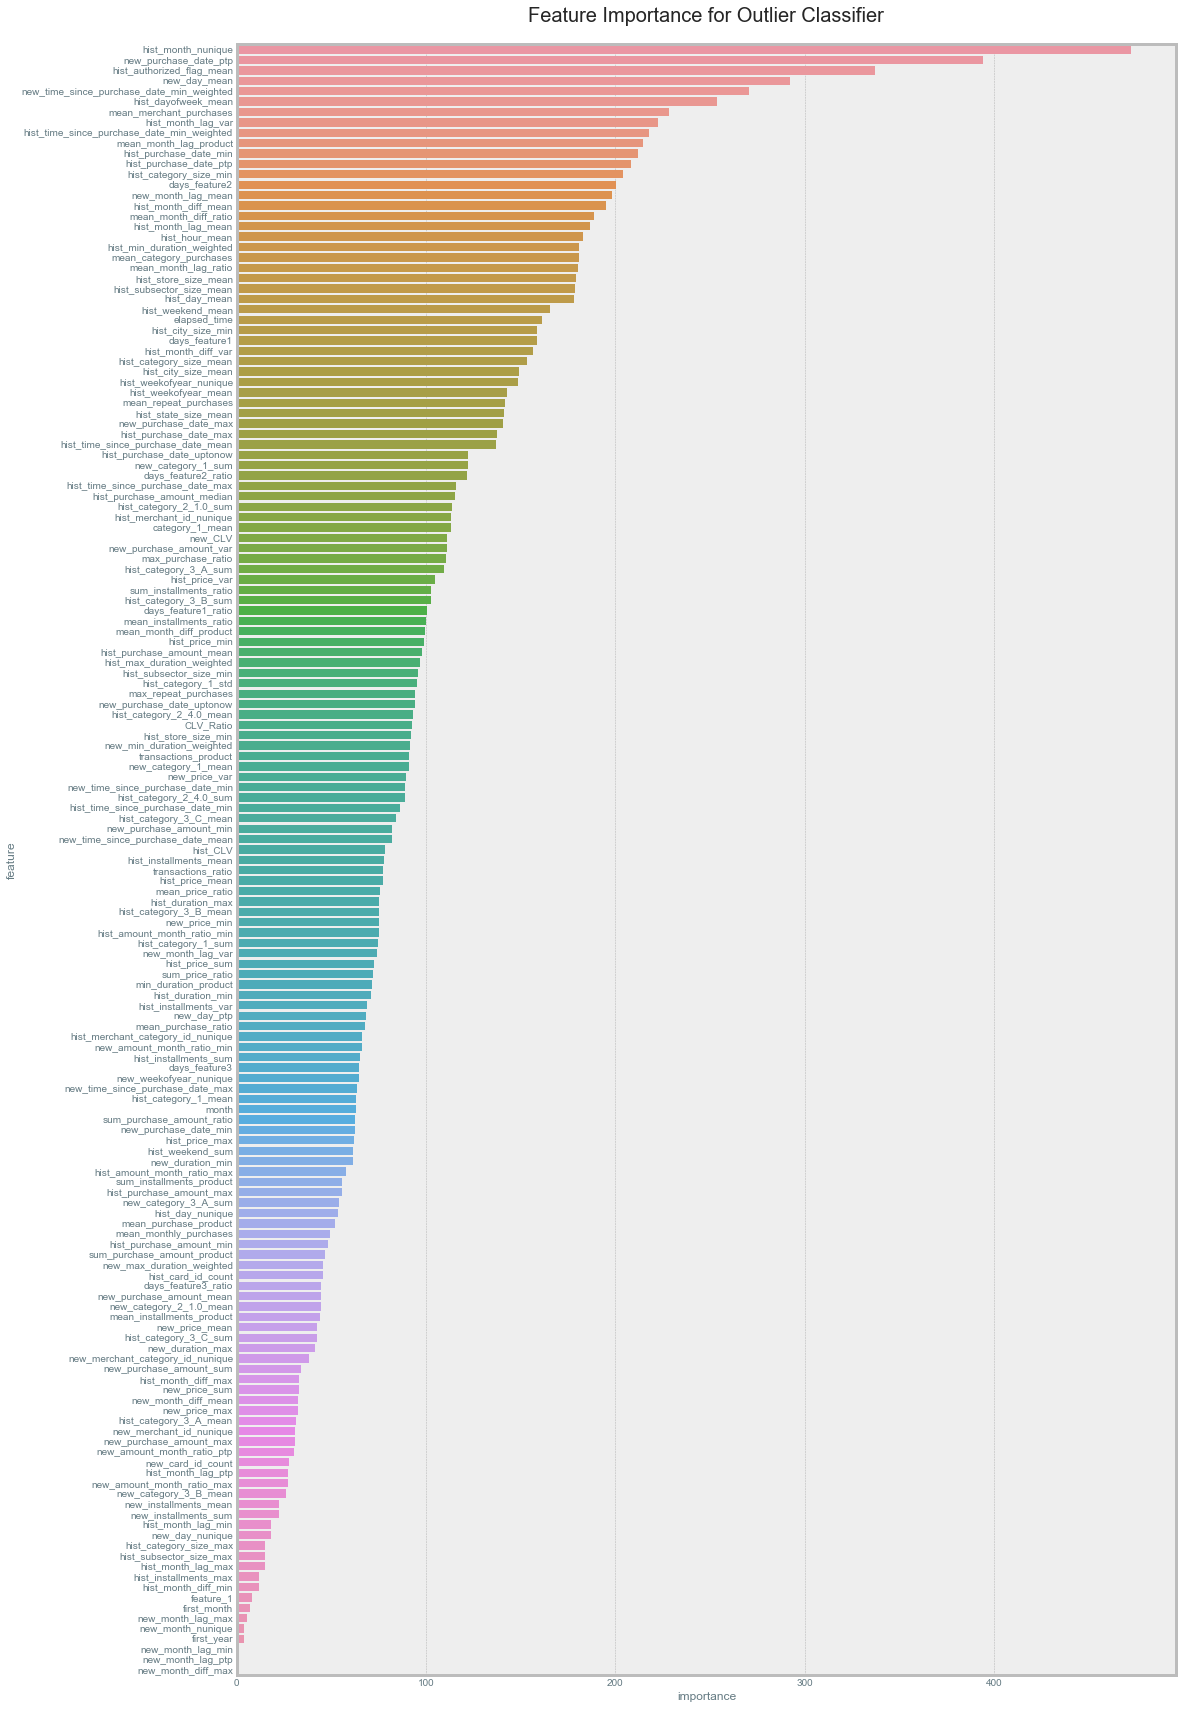

In [163]:
plt.figure(figsize=(15,30))
class_feature_imp_df = class_feature_importance.groupby('feature').mean().reset_index()
class_feature_imp_df.sort_values('importance',inplace = True,ascending=False)
sns.barplot(y='feature',x='importance',data=class_feature_imp_df)
plt.title('Feature Importance for Outlier Classifier',size=20,y=1.01)
plt.show()

### 3. Huber Regression LGBM (Less Sensitive to Outliers)

In [15]:
huber_params ={
        'task': 'train',
        'boosting': 'gbdt',
        'objective': 'huber',
        'metric': 'huber',
        'learning_rate': 0.01,
        'subsample': 0.95,
        'max_depth': 7,
        'top_rate': 0.91,
        'num_leaves': 63,
        'min_child_weight': 41.96,
        'other_rate': 0.072,
        'reg_alpha': 9.67,
        'colsample_bytree': 0.566,
        'min_split_gain': 9.82,
        'reg_lambda': 8.25,
        'min_data_in_leaf': 21,
        'verbose': -1,
        'seed':2333,
        }

state = 16
huber_oof,huber_pred,huber_feature_importance = lgb_cv(features,huber_params,5,state)
print('RMSE:',np.sqrt(mean_squared_error(huber_oof, target)))
print('~'*20)

fold number: 1
fold number: 2
fold number: 3
fold number: 4
fold number: 5
RMSE: 3.808435212222509
~~~~~~~~~~~~~~~~~~~~


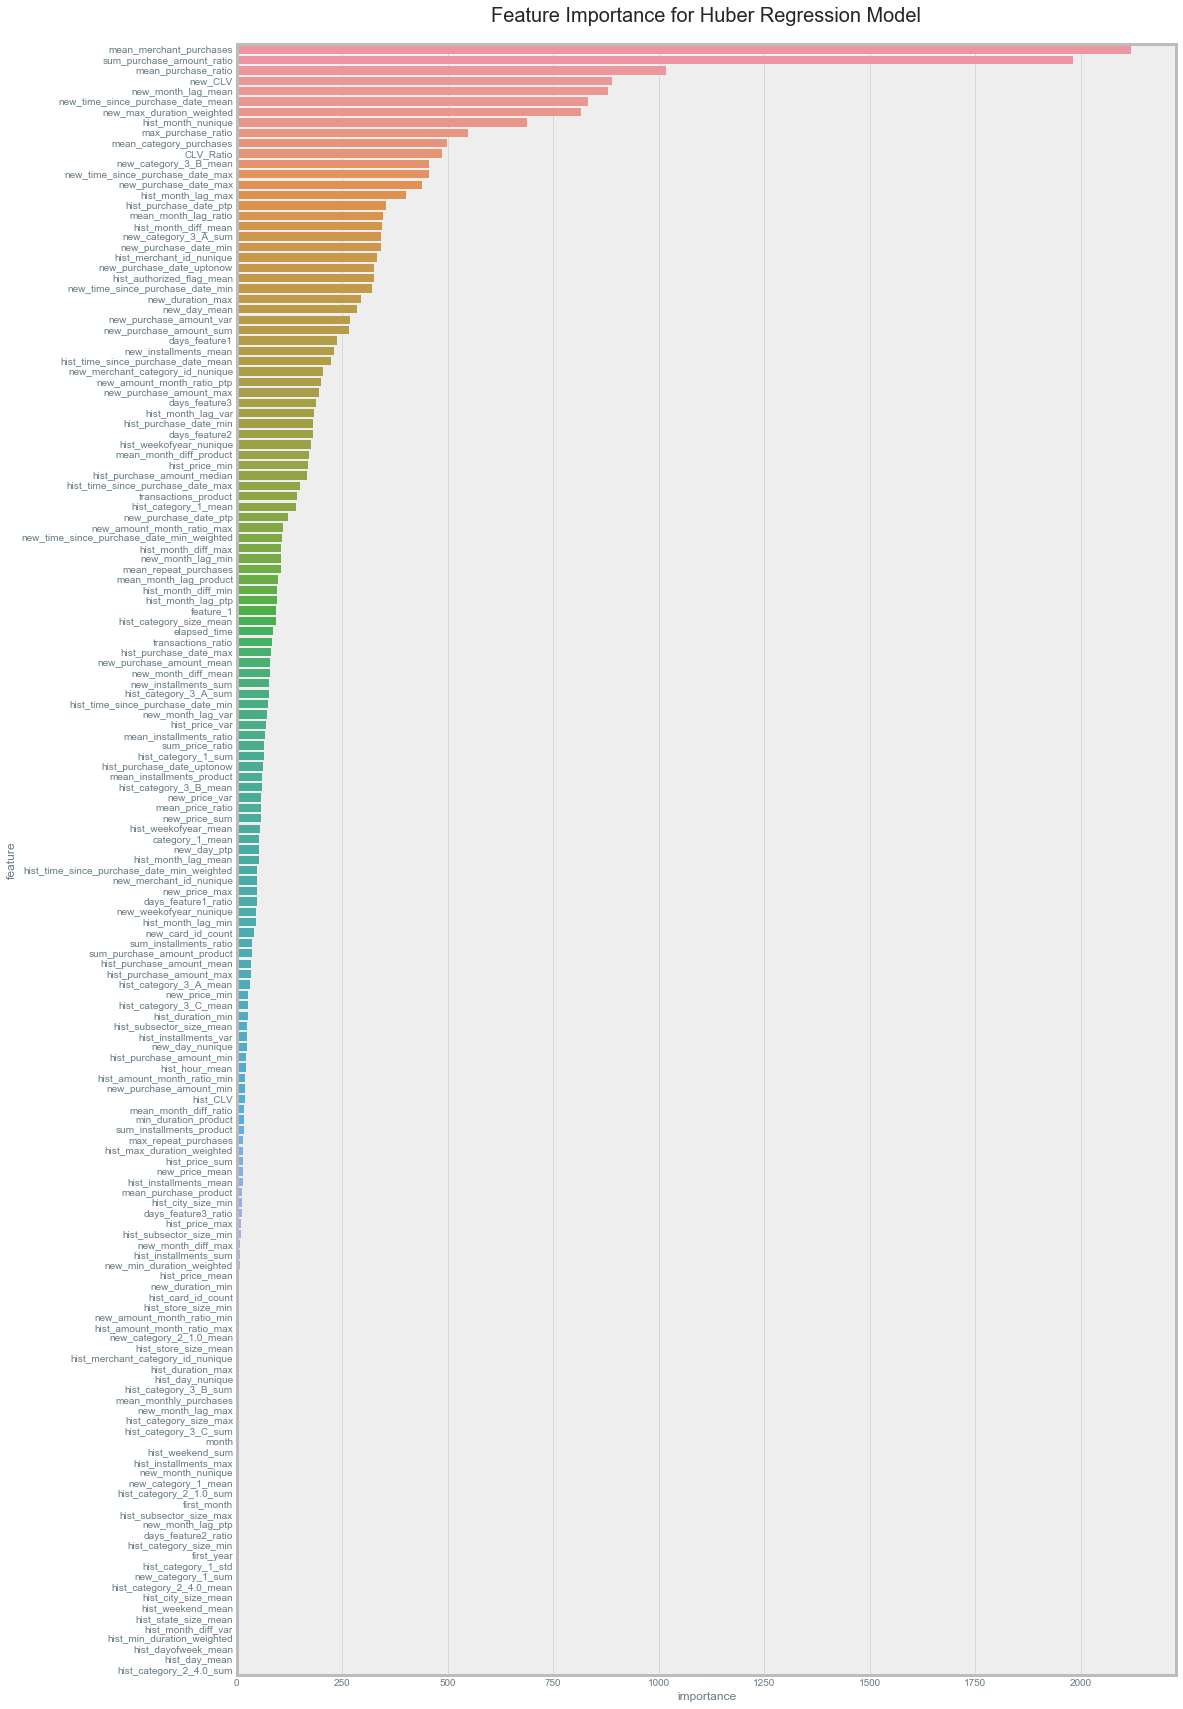

In [164]:
plt.figure(figsize=(15,30))
huber_feature_imp_df = huber_feature_importance.groupby('feature').mean().reset_index()
huber_feature_imp_df.sort_values('importance',inplace = True,ascending=False)
sns.barplot(y='feature',x='importance',data=huber_feature_imp_df)
plt.title('Feature Importance for Huber Regression Model',size=20,y=1.01)
plt.show()

We can see from each of these models feature importances that the presence of outliers greatly impact how our model predicts customer loyalty. For example in our Huber regression model the most useful feature was Mean Merchant Purchases. One would expect this feature to be highly predictive of loyalty as its essentially a metric of just that. However the fact that it was not weighted as highly in the RMSE LGBM and outlier classifier indicates that it was relatively less effective at predicting outliers. Further more we can see that when the model doesn't weight outliers as highly the importance of several features drops to zero. A seperate Feature Selection for Huber Regression could have likely been an appropriate measure.

### 4. Stacking a Linear Model

In [16]:
def level_2_trainer(model,x,test_pred):
    
    folds = model_selection.StratifiedKFold(n_splits=5,shuffle=True,random_state=10)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    weights = np.zeros(len(x.columns))
    for fold_, (train_index,valid_index) in enumerate(folds.split(train,train['outliers'].values)):

        start = time.time()
        
        # Train and Validation Split
        train_x = x.iloc[train_index]
        train_y = target.iloc[train_index]
        val_x = x.iloc[valid_index]
        val_y = target.iloc[valid_index]
        
        # Train Model and Get Predictions
        model.fit(train_x,train_y)
        oof[valid_index] = model.predict(val_x)
        predictions += model.predict(test_pred)/folds.n_splits
        weights += model.coef_/folds.n_splits
    
    print('CV Score:',np.sqrt(mean_squared_error(oof, target)),'\n')
    for col,weight in zip(x.columns,weights):
        print(f"{col} Model Weights:{weight:0.3f}")
    return oof, predictions, model

In [19]:
x_train = pd.DataFrame()
x_test = pd.DataFrame()

x_train['lgbm'] = lgb_oof
x_train['huber'] = huber_oof
x_train['classifier'] = class_oof

x_test['lgbm'] = lgb_pred
x_test['huber'] = huber_pred
x_test['classifier'] = class_pred

lin_model = linear_model.LinearRegression()
oof, predictions, _ = level_2_trainer(lin_model,x_train,x_test)

CV Score: 3.6437266975653024 

lgbm Model Weights:0.653
huber Model Weights:0.483
classifier Model Weights:-12.887


In [21]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df['target'] = predictions
sub_df.to_csv("ELOSUBMISSION.csv", index=False)
sub_df.head()

,card_id,target
0,C_ID_0ab67a22ab,-3.009050
1,C_ID_130fd0cbdd,-0.148055
2,C_ID_b709037bc5,-0.648368
3,C_ID_d27d835a9f,-0.044361
4,C_ID_2b5e3df5c2,-1.434829


Submission is slightly different from final submission used, but still scores in the top 5%

## Effect of Outliers on RMSE

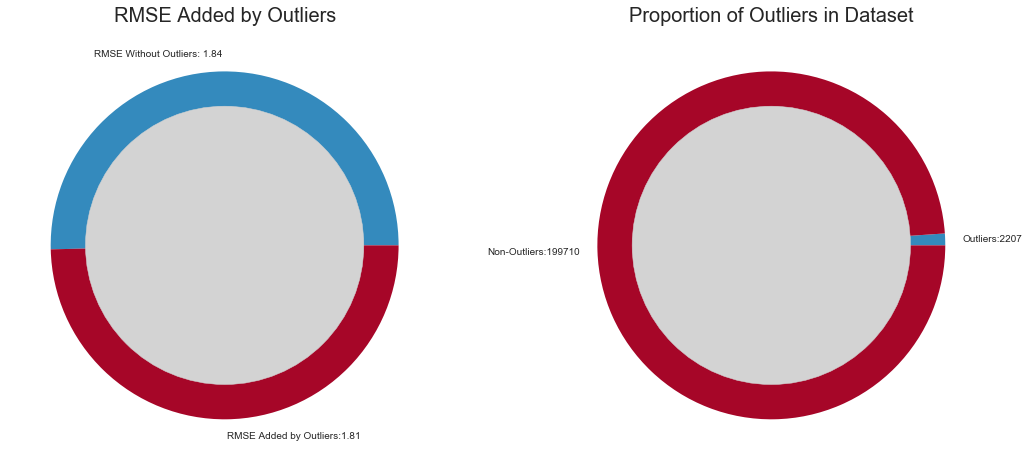

In [162]:
total_rmse = np.sqrt(mean_squared_error(oof, target))
rmse_without_outliers = np.sqrt(mean_squared_error(oof[train['outliers']==0], target[train['outliers']==0]))
noutliers = sum(train['outliers'])
n = len(train)

names = [f'RMSE Without Outliers: {rmse_without_outliers:.2f}',f'RMSE Added by Outliers:{(total_rmse-rmse_without_outliers):.2f}']
size = [rmse_without_outliers,total_rmse-rmse_without_outliers]

names2 = [f'Outliers:{noutliers}',f'Non-Outliers:{n-noutliers}']
size2 = [sum(train['outliers']),(len(train)-sum(train['outliers']))]

f,axes = plt.subplots(1,2,figsize = (16,8))
my_circle = plt.Circle( (0,0), 0.8, color='lightgrey')
my_circle2 = plt.Circle( (0,0), 0.8, color='lightgrey')

axes[0].pie(size, labels=names)
axes[0].add_artist(my_circle)
axes[0].set_title('RMSE Added by Outliers',size=20)

axes[1].pie(size2, labels=names2)
axes[1].add_artist(my_circle2)
axes[1].set_title('Proportion of Outliers in Dataset',size=20)
plt.show()

These last plots illustrate what a huge role outliers played in this competition. Though they make up only ~1% of the data they are the cause of almost 50% of the error. Dealing with these outliers, and not overfitting to outliers in the public LB, was what seperated much of the scores in this competition.

---